In [1]:
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import scipy.spatial.qhull as qhull
import matplotlib.tri as mtri
%matplotlib inline
import matplotlib.cm as cm
xr.set_options(display_style="text") # make it look better when posted online. Comment to get nicer representation of xarrays

In /global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

We can try to work with several model setups for comparison:


    /work/ollie/nkolduno/output_orca20
    /work/ollie/nkolduno/meshes/FORCA20

    /work/ollie/nkolduno/output_orca15_wsplit
    /work/ollie/nkolduno/meshes/FORCA15

    /work/ollie/nkolduno/output_D3_70
    /work/ollie/nkolduno/meshes/D3_70

    /work/ollie/nkolduno/output_orca12/
    /work/ollie/nkolduno/meshes/FORCA12/


I suggest we begin with FORCA12, as most eddy rich setup.

Load data

In [2]:
data = xr.open_dataset('/work/ollie/nkolduno/output_orca12/ssh.fesom.1961.nc')

In [3]:
data

<xarray.Dataset>
Dimensions:  (nod2: 8852366, time: 365)
Coordinates:
  * time     (time) datetime64[ns] 1961-01-01T23:56:00 ... 1961-12-31T23:56:00
Dimensions without coordinates: nod2
Data variables:
    ssh      (time, nod2) float32 ...
Attributes:
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       233d72b
    FESOM_MeshPath:                      /work/ollie/nkolduno/meshes/FORCA12/
    FESOM_mesh_representative_checksum:  81755fcf951e7f4507b4952df42b8cdd
    FESOM_ClimateDataPath:               /work/ollie/clidyn/FESOM2/hydrograph...
    FESOM_which_ALE:                     zstar
    FESOM_mix_scheme:                    KPP
    FESOM_tra_adv_hor:                   MFCT
    FESOM_tra_adv_ver:                   QR4C
    FESOM_tra_adv_lim:                   FCT
    FESOM_use_partial_cell:              -1
    FESOM_force_rotation:                -1
    FESOM_include_fleapyear:             -1
    FESOM_use_floatice:                  0
    FESOM_whichEVP:                      1
    FESOM_evp_rheol_steps:               120
    FESOM_visc_option:                   5
    FESOM_w_split:                       0

Load model grid

In [4]:
grid = xr.open_dataset('/work/ollie/nkolduno/meshes/FORCA12/fesom.mesh.diag.nc')

In [5]:
grid

<xarray.Dataset>
Dimensions:            (N: 8, edg_n: 26481174, elem: 17628297, n2: 2, n3: 3, n4: 4, nod2: 8852366, nz: 70, nz1: 69)
Coordinates:
  * nz                 (nz) float64 0.0 -5.0 -10.0 ... -6e+03 -6.35e+03
  * nz1                (nz1) float64 -2.5 -7.5 -12.5 ... -5.825e+03 -6.175e+03
Dimensions without coordinates: N, edg_n, elem, n2, n3, n4, nod2
Data variables:
    elem_area          (elem) float64 ...
    nlevels_nod2D      (nod2) int32 ...
    nlevels            (elem) int32 ...
    nod_in_elem2D_num  (nod2) int32 ...
    nod_part           (nod2) int32 ...
    elem_part          (elem) int32 ...
    zbar_e_bottom      (elem) float64 ...
    zbar_n_bottom      (nod2) float64 ...
    lon                (nod2) float64 ...
    lat                (nod2) float64 ...
    nod_area           (nz, nod2) float64 ...
    elements           (n3, elem) int32 ...
    nodes              (n2, nod2) float64 ...
    nod_in_elem2D      (N, nod2) int32 ...
    edges              (n2, edg_n) int32 ...
    edge_tri           (n2, edg_n) int32 ...
    edge_cross_dxdy    (n4, edg_n) float64 ...
    gradient_sca_x     (elem, n3) float64 ...
    gradient_sca_y     (elem, n3) float64 ...

Extract lon lat from the frid file, and also take one step from the data:

In [4]:
model_lon = grid.lon.values
model_lat = grid.lat.values
data_sample = data.ssh[0,:].values

Plot things, just to make sure the data are OK

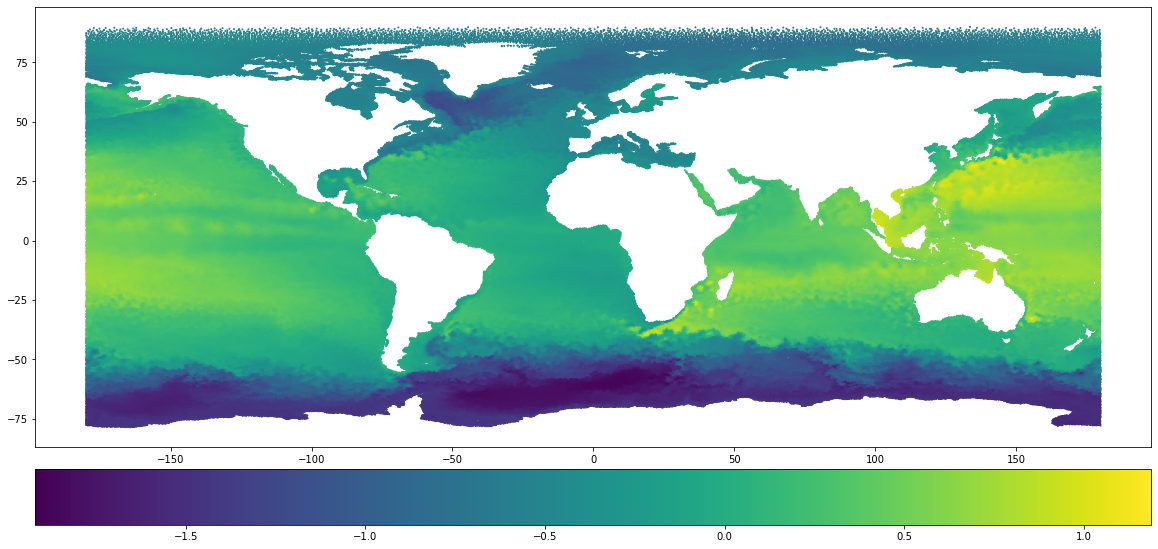

In [5]:
plt.figure(figsize=(20,10))
plt.scatter(model_lon[::20], model_lat[::20], s=1 , c=data_sample[::20])
plt.colorbar(orientation='horizontal', pad=0.04)

## Simple interpolation to a regular grid

This is our region:

    left: 70°W
    right: 30°E
    top: 20°S
    bottom: 60°S

Define targer regular grid, that has more or less similar resolution to the model grid. One can increas resolution of the target grid and potentially get better results:

In [6]:
lon = np.linspace(-70, 30, 100*12*2)
lat = np.linspace(-60, -20, 40*12*2)
lon2, lat2 = np.meshgrid(lon, lat)

For interpolation routines, we have to have model coordinates in this format:

In [7]:
#fesom
points = np.vstack((model_lon, model_lat)).T

Do the simplest nearest neighbor interpolation:

In [8]:
%%time
nn_interpolation = NearestNDInterpolator(points, data_sample)

CPU times: user 2min 52s, sys: 120 ms, total: 2min 52s
Wall time: 2min 52s


In [9]:
%%time
interpolated_nn_fesom = nn_interpolation((lon2, lat2))

CPU times: user 4.48 s, sys: 32 ms, total: 4.51 s
Wall time: 4.51 s


And plot the results.

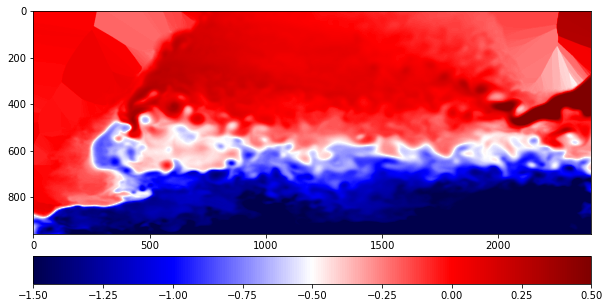

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(np.flipud(interpolated_nn_fesom), cmap=cm.seismic, vmin=-1.5, vmax=0.5)
plt.colorbar(orientation='horizontal', pad=0.04)

Things were quite fast, butneares neibor is not the most precise interpolation method on Earth (although it might be that for our perpoces it's just fine, something to check).

The bigger problem is that there is extrapolation over continents, and that's we don't like.

So, let's, try to use some more advance method, that actually aware of our grid, and that don't extrapolate where it shouldn't.

## Linear interpolation with triangular grid

We need information about the grid structure

In [11]:
elements = (grid.elements.data.astype('int32') - 1).T

In [12]:
elements

array([[      0,       6,       3],
       [      0,       1,       2],
       [      0,       3,       1],
       ...,
       [8852360, 8852362, 8852364],
       [8852362, 8852363, 8852364],
       [8852363, 8852365, 8852364]], dtype=int32)

Unfortunatelly elements that we get from FESOM2 are not ideal for plotting and interpolation, since some of the triangles have coordinates like:

[ 176.9465, -179.3587,  163.4757]

This triangle is close to +-180 meredian, and this is not valid for matplotlib triangulation (it thinks that triangles are overlaping). The easiest way to deal with it is to remove triangles, that have this kind of points. Something you certainly don't want to do for computing integrals, but for most simple analysis and visualizations is fine.

We search for elements that have lon coordinates that differe by 100 degrees and return a list (no_cyclic_elem) of elements that don't have such elements.

In [13]:
d = model_lon[elements].max(axis=1) - model_lon[elements].min(axis=1)
no_cyclic_elem = np.argwhere(d < 100).ravel()

Here we create matplotlib triangulation, that consist of only non cyclic triangles:

In [14]:
triang = mtri.Triangulation(model_lon, model_lat, elements[no_cyclic_elem])

And here we create interpolator, and provide target coordinates for interpolation (which will take loooong time):

however, it is possible to create the interpolator outside of the parallel task, so it has to be done only once and then provide the interpolator to the interpolation function

In [ ]:
tri = triang.get_trifinder()

In [18]:
%%time
masked_data = mtri.LinearTriInterpolator(triang, data_sample,trifinder=tri)(lon2, lat2)

CPU times: user 9.6 s, sys: 2.67 s, total: 12.3 s
Wall time: 8.84 s


Plot the thing:

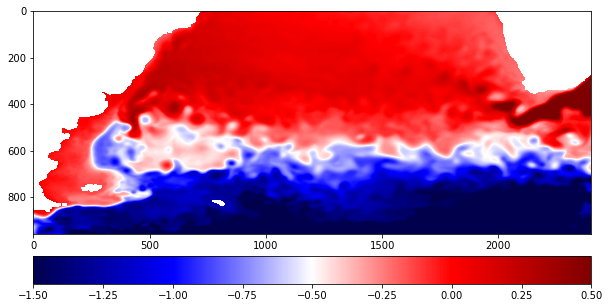

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(np.flipud(masked_data), cmap=cm.seismic, vmin=-1.5, vmax=0.5)
plt.colorbar(orientation='horizontal', pad=0.04)

You can see that continents are now fine and we can use those data, but it is really slow. It remains to be seing if we have to use nearest neighbor or linear interpolation, but we certainly, even for the neares neighbor one don't want to have continents. The easy way to fix it for the nearest neighbor is to apply the mask from out linear interpolation, that in this case we should do only once (mask will be the same for all timesteps).

In [16]:
mask = masked_data.mask

Convert out nearest neibor interpolated data to masek array with mask from linear interpolated data:

In [17]:
interpolated_nn_fesom_masked = np.ma.array(interpolated_nn_fesom, mask=mask)

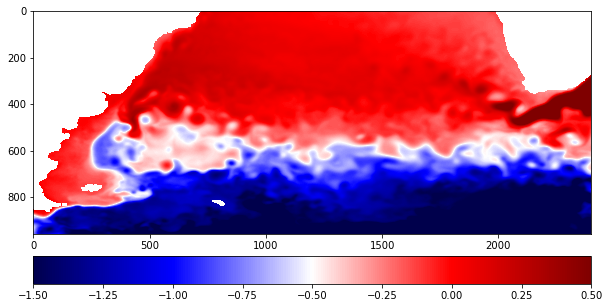

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(np.flipud(interpolated_nn_fesom_masked), cmap=cm.seismic, vmin=-1.5, vmax=0.5)
plt.colorbar(orientation='horizontal', pad=0.04)

Suggested tasks from my side:

- create a workflow to interpolate SSH data from different runs, for different years, and save them in the format that can be used by py-eddy-tracker.
- there should be possibility to change the region and change FESOM simulations. It also preferably should do interpolations in parallel as this is embarrassingly parallel task.
- Compare fields interpolated with nearest neighbor and linear interpolation - are results significantly differ? Does it depend on the resolution of the target grid?
